# How does a French learners' vocabulary grow over time when 1T Sentence-Mining the first Harry Potter book?

--- **Quick note**: *this analysis is a smaller part of a much larger analysis that will be explained in much more depth and clarity in the future. Apologies to any reader who may find this analysis a little too terse.*

This short analysis aims to track how a relative beginner in French may grow their vocabulary by 1T Sentence-Mining the French version of the first Harry Potter (*Harry Potter à l'école des sorciers*). 

[Sentence-Mining](https://refold.la/roadmap/stage-2/a/basic-sentence-mining) is the practice of collecting (mining) sentences in a foreign language that a language-learner would like to study. A sentence is said to be 1T when the learner is able to understand every word in the sentence except for exactly one. 1T sentences are very commonly used to build flashcards where, the front of the card contains the 1T sentence and the back of the card contains the definition (or translation) of the previously unknown word. From mining each 1T sentences, looking up the meaning of each unknown word and building flashcards from these sentence/definiton pairs, a learner can very quickly build up their vocabulary in a foreign language through reading books.

This particular book was chosen for the analysis due to it's popularity as a 'first-novel' among many French learners.

In this analysis we make the naive assumption that the learner has knowledge of the 5000 most common French words used in books and that they have no knowledge of any other words or conjugations outside of these first 5000. The reason for choosing the number 5000 is that it actually represents a very small vocabulary in French and that I believe it to be a reasonable vocabulary size for a learner to have before attempting to read the first Harry Potter.

Data used in this analysis includes a French Frequency List taken from [Lexique](http://www.lexique.org/) and the text contained in J.K Rowling's [Harry Potter à l'école des sorciers](https://www.amazon.fr/Harry-Potter-%C3%A0-l%C3%A9cole-sorciers/dp/2070518426).

## Libraries

In [1]:
import numpy as np
import pandas as pd
import spacy
import nltk
import matplotlib.pyplot as plt

#french language processor
nlp_fr = spacy.load('fr_core_news_sm')

## Relevant Datasets

In [2]:
#Frequency list for all French words
freq_list = pd.read_csv('freq_list.csv')

#text data corresponding to each chapter in the book
df_hp1 = pd.read_csv('Harry Potter/1/book_df.csv')

#Frequency list containing all words found in the first Harry Potter
freq_list_hp1 = pd.read_csv('Harry Potter/1/freq_list.csv', index_col=0)

## Known Words

Here we build two datasets for representing the words that the French learner knows and does not know.

One dataset contains all French words and the other contains only words found in the book (this is used to speed up some of the computations that will be perfomed).

In [3]:
known_words = freq_list.copy()

#known_words doesn't need frequency
known_words = known_words[['word']]

#column for whether a word is known
known_words['known'] = 0

#say that the first 5000 words are known
known_words.loc[:4999, 'known'] = 1

#limit to only words that occur in the first Harry Potter
known_words_hp1 = known_words.loc[freq_list_hp1.index]

## Functions

In [4]:
#returns unknown words found in the sentence, based on known_words
def get_T(sentence):
    
    #tokenize the sentence
    tokens = nlp_fr(sentence.lower())
    
    #T counts number of unknown words in the sentence
    T = 0
    #returns the unknown word
    unknown_words = set()
    
    for word in tokens:
        
        #looks for the word in the harry potter frequency list
        rslt = known_words_hp1.loc[known_words_hp1['word'] == word.text, 'known']
        
        #does it even exist in the frequency list?
        if len(rslt) != 0:
            
            #the word is not a known word
            if int(rslt) == 0:
            
                unknown_words.add(word.text)
            
    return list(unknown_words)

In [5]:
#returns a list of the learned words after having read a given
#chapter of Harry Potter
def sentence_mine(chapter):
    
    #break the individual chapter into sentences
    sentences = nltk.tokenize.sent_tokenize(chapter, language="french")
    
    #initialize a dataframe to contain the chapters' 1T sentences and
    #corresponding learned-words
    one_T_df = pd.DataFrame(columns=['sentence', 'word'])
    for sentence in sentences:
    
        #returns all unknown words from sentence
        rslt = get_T(sentence)
    
        #if T==1
        if len(rslt) == 1:
        
            unknown_word = rslt[0]
        
            row = pd.DataFrame({'sentence':[sentence], 'word':[unknown_word]})
        
            one_T_df = one_T_df.append(row)
            
    #many different sentences may be 1T and contain the new word
    #this keeps only the first 1T sentence where the word occurs
    one_T_df = one_T_df.drop_duplicates(subset=['word'])
    #reset index for good measure
    one_T_df = one_T_df.reset_index(drop=True)
    
    #extract learned words
    learned_words = list(one_T_df['word'].values)
    
    return learned_words

In [6]:
#updates the known words in the frequency lists
#it updates the harry potter known words and the global known words
def update_known_words(learned_words):
    
    #update known_words
    for word in learned_words:
        
        #update the harry potter specific words to help find new unknown words in the book
        known_words_hp1.loc[known_words['word'] == word, 'known'] = 1
        #update the overall unknown words so that we can see how vocabulary is growing
        known_words.loc[known_words['word'] == word, 'known'] = 1

## The Simulation

Below, we iterate over each chapter of Harry Potter à l'école des sorciers and 1T sentence-mine them. After each chapter we print the learner's current vocabulary size.

In [7]:
#vocabulary size before reading harry potter 1
vocab_init = known_words['known'].sum()
print('Initial Vocabulary Size:', vocab_init, 'words.')
print('------------------------------------\n')

#keeps track of vocabulary size before and after each chapter
learned_words_data = pd.DataFrame(columns=['Chapter', 'Vocab_Before', 'Vocab_After'])

#iterate through the chapters of the book
for index in range(len(df_hp1)):
    
    #read a chapter
    chapter = df_hp1.loc[index, 'Text']
    
    #sentence mine the chapter to get learned words
    learned_words = sentence_mine(chapter)
    
    #num words known before sentence mining the chapter
    vocab_before = known_words['known'].sum()
    
    #update words known
    update_known_words(learned_words)
    
    #num words known after sentence mining the chapter
    vocab_after = known_words['known'].sum()
    
    #update learned_words_data
    new_data = pd.DataFrame({'Chapter':[index+1], 'Vocab_Before':[vocab_before], 'Vocab_After':[vocab_after]})
    learned_words_data = learned_words_data.append(new_data)
    
    print('After reading Chapter:', index+1)
    print('Vocabulary Size:', vocab_after, '\n')

#so that not all indices are 0
learned_words_data = learned_words_data.reset_index(drop=True)
#new words learned each chapter
learned_words_data['Learned_Words'] = learned_words_data['Vocab_After'] - learned_words_data['Vocab_Before']
#percentage increase in vocabulary size after reading each chapter
learned_words_data['Vocab_Perc_Inc'] = 100*learned_words_data['Learned_Words']/learned_words_data['Vocab_Before']
    
#vocabulary size after reading harry potter 1
vocab_final = known_words['known'].sum()

#number of words learned in reading harry potter 1
learned_words_total = vocab_final - vocab_init

#percenteage increase in vocabulary size after reading harry potter 1
perc_inc_total = 100 * (learned_words_total) / vocab_init

print('Total Words Learned:', learned_words_total)
print('Final Vocabulary Size:', vocab_final, 'words.')
print('Total Vocabulary Increase: ', perc_inc_total, '%', sep='')

Initial Vocabulary Size: 5000 words.
------------------------------------

After reading Chapter: 1
Vocabulary Size: 5101 

After reading Chapter: 2
Vocabulary Size: 5175 

After reading Chapter: 3
Vocabulary Size: 5274 

After reading Chapter: 4
Vocabulary Size: 5366 

After reading Chapter: 5
Vocabulary Size: 5513 

After reading Chapter: 6
Vocabulary Size: 5624 

After reading Chapter: 7
Vocabulary Size: 5736 

After reading Chapter: 8
Vocabulary Size: 5792 

After reading Chapter: 9
Vocabulary Size: 5911 

After reading Chapter: 10
Vocabulary Size: 6017 

After reading Chapter: 11
Vocabulary Size: 6090 

After reading Chapter: 12
Vocabulary Size: 6183 

After reading Chapter: 13
Vocabulary Size: 6254 

After reading Chapter: 14
Vocabulary Size: 6334 

After reading Chapter: 15
Vocabulary Size: 6462 

After reading Chapter: 16
Vocabulary Size: 6593 

After reading Chapter: 17
Vocabulary Size: 6719 

Total Words Learned: 1719
Final Vocabulary Size: 6719 words.
Total Vocabulary Increa

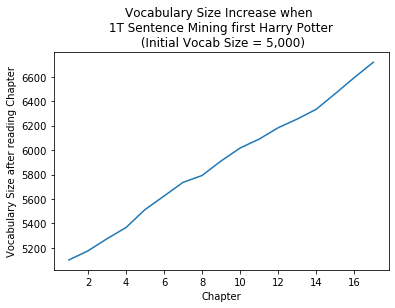

In [8]:
plt.plot(learned_words_data['Chapter'], learned_words_data['Vocab_After'])

plt.title('Vocabulary Size Increase when \n 1T Sentence Mining first Harry Potter \n (Initial Vocab Size = 5,000)')

plt.xlabel('Chapter')

plt.ylabel('Vocabulary Size after reading Chapter')

plt.show()

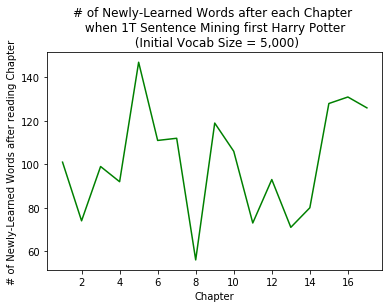

In [9]:
plt.plot(learned_words_data['Chapter'], learned_words_data['Learned_Words'], color='g')

plt.title('# of Newly-Learned Words after each Chapter \n when 1T Sentence Mining first Harry Potter \n (Initial Vocab Size = 5,000)')

plt.xlabel('Chapter')

plt.ylabel('# of Newly-Learned Words after reading Chapter')

plt.show()

As a brief sanity check, I should mention that this graph largely fits with my experience. I remember that after reading the first chapter on my own, I had mined just under 100 sentences and that the following chapters usually left me with around 70 or so sentences.

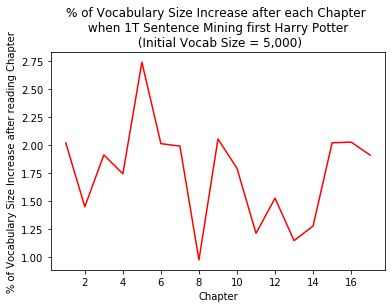

In [10]:
plt.plot(learned_words_data['Chapter'], learned_words_data['Vocab_Perc_Inc'], color='r')

plt.title('% of Vocabulary Size Increase after each Chapter \n when 1T Sentence Mining first Harry Potter \n (Initial Vocab Size = 5,000)')

plt.xlabel('Chapter')

plt.ylabel('% of Vocabulary Size Increase after reading Chapter')

plt.show()

As subtle as it may appear, there is more clear evidence of an overall downward trend in `Vocab_Perc_Inc` than in `Learned_words`.

So to summarise, starting with a limited vocabulary of 5,000 French words the learner was able to grow their vocabulary 34% by 1T sentence-mining the first Harry Potter book.

Thanks for reading!